# Example: Introduction to topsbm

Topic modelling with hierarchical stochastic block models

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from topsbm import TopSBM

## Setup: Load a corpus

1. We have a list of documents, each document contains a list of words.
1. We have a list of document titles (optional)

The example corpus consists of 63 articles from Wikipedia taken from 3 different categories (Experimental Physics, Chemical Physics, and Computational Biology).

We use scikit-learn's [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to turn this text into a feature matrix.

In [2]:
# Load texts and vectorize
with open('corpus.txt', 'r') as f:
    docs = f.readlines()

vec = CountVectorizer(token_pattern=r'\S+')
X = vec.fit_transform(docs)

# X is now a sparse matrix of (docs, words)

# titles corresponding to docs
with open('titles.txt', 'r') as f:
    x = f.readlines()
titles = [h.split()[0] for h in x]

In [3]:
# view the data for document 0
print(titles[0])
print(docs[0][:100])

Nuclear_Overhauser_effect
 the nuclear overhauser effect noe is the transfer of nuclear spin polarization from one nuclear spi


## Fit the model

Calling `TopSBM.fit_transform` will:
* construct the bipartite graph between documents and words (samples and features)
* perform Hierarchical Stochastic Block Model inference over the graph
* return an embedding of the samples in the block level with finest granularity

In [18]:
model = TopSBM(random_state=9)
Xt = model.fit_transform(X)

## Plotting the graph and block structure

The following plot shows the (hierarchical) community structure in the word-document network as inferred by the stochastic block model:

* document-nodes are on the left
* word-nodes are on the right
* different colors correspond to the different groups

The result is a grouping of nodes into groups on multiple levels in the hierarchy:

* on the uppermost level, each node belongs to the same group (square in the middle)
* on the next-lower level, we split the network into two groups: the word-nodes and the document-nodes (blue sqaures to the left and right, respectively). This is a trivial structure due to the bipartite character of the network.
* only next lower levels constitute a non-trivial structure: We now further divide nodes into smaller groups (document-nodes into document-groups on the left and word-nodes into word-groups on the right)

In the code, the lowest level is known as level 0, with coarser levels 1, 2, ...

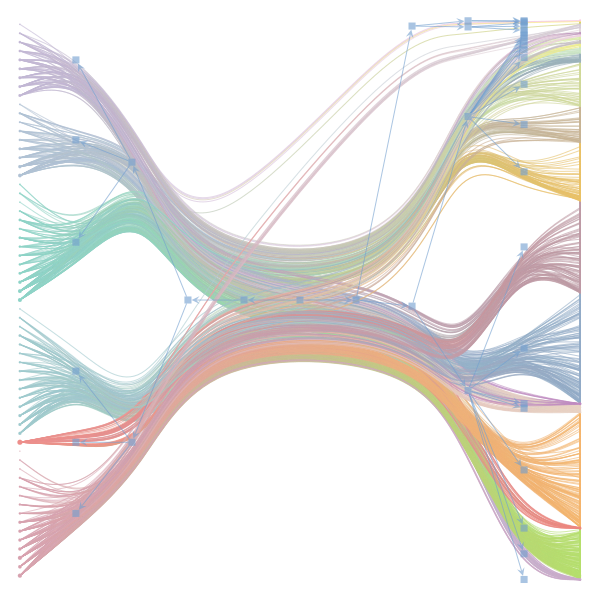

In [19]:
model.plot_graph(n_edges=1000)

## Topics

For each word-group on a given level in the hierarchy, we retrieve the $n$ most common words in each group -- these are the topics!

In [20]:
topics = pd.DataFrame(model.groups_[1]['p_w_tw'],
                      index=vec.get_feature_names())

In [21]:
for topic in topics.columns:
    print(topics[topic].nlargest(10))
    print()

the    0.006768
of     0.006661
a      0.006554
in     0.006446
is     0.006446
to     0.006339
and    0.006124
for    0.005372
an     0.005264
as     0.005264
Name: 0, dtype: float64

when       0.008921
where      0.008058
first      0.006619
given      0.006331
if         0.006331
field      0.006043
applied    0.005755
because    0.005755
e          0.005468
energy     0.005468
Name: 1, dtype: float64

computational    0.060606
development      0.055556
proteins         0.045455
open             0.040404
protein          0.040404
software         0.040404
community        0.035354
researchers      0.035354
core             0.025253
identify         0.025253
Name: 2, dtype: float64

point       0.217391
formula     0.188406
must        0.144928
wave        0.115942
spectrum    0.086957
air         0.072464
plane       0.057971
flow        0.043478
q           0.043478
mode        0.028986
Name: 3, dtype: float64



## Topic-distribution in each document

Which level-1 topics contribute to each document?

In [22]:
pd.DataFrame(model.groups_[1]['p_tw_d'],
             columns=titles)

,Nuclear_Overhauser_effect,Quantum_solvent,Rovibrational_coupling,Effective_field_theory,Chemical_physics,Rotational_transition,Dynamic_nuclear_polarisation,Knight_shift,Polarizability,Anisotropic_liquid,...,Louis_and_Beatrice_Laufer_Center_for_Physical_and_Quantitative_Biology,Law_of_Maximum,Enzyme_Function_Initiative,SnoRNA_prediction_software,Sepp_Hochreiter,Aureus_Sciences,IEEE/ACM_Transactions_on_Computational_Biology_and_Bioinformatics,Knotted_protein,BioUML,De_novo_transcriptome_assembly
0,0.608392,0.856,0.523529,0.804651,0.82,0.648649,0.584192,0.582418,0.493274,0.645161,...,0.907692,0.851351,0.857143,0.857143,0.846690,0.822222,0.84375,0.773585,0.870647,0.868932
1,0.391608,0.144,0.458824,0.190698,0.16,0.337838,0.412371,0.406593,0.500000,0.354839,...,0.092308,0.121622,0.095238,0.142857,0.139373,0.133333,0.09375,0.169811,0.084577,0.092233
2,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.010989,0.002242,0.000000,...,0.000000,0.027027,0.044218,0.000000,0.013937,0.044444,0.06250,0.047170,0.044776,0.038835
3,0.000000,0.000,0.017647,0.004651,0.02,0.013514,0.003436,0.000000,0.004484,0.000000,...,0.000000,0.000000,0.003401,0.000000,0.000000,0.000000,0.00000,0.009434,0.000000,0.000000


## Extra: Clustering of documents - for free.

The stochastic block models clusters the documents into groups. We do not need to run an additional clustering to obtain this grouping.

For a query article, we can return all articles from the same group

In [23]:
cluster_labels = pd.DataFrame(model.groups_[1]['p_td_d'],
                              columns=titles).idxmax(axis=0)
cluster_idx = cluster_labels['Rovibrational_coupling']
cluster_labels[cluster_labels == cluster_idx]

Nuclear_Overhauser_effect                        0
Rovibrational_coupling                           0
Rotational_transition                            0
Dynamic_nuclear_polarisation                     0
Knight_shift                                     0
Polarizability                                   0
Anisotropic_liquid                               0
Rotating_wave_approximation                      0
Molecular_vibration                              0
Fuel_mass_fraction                               0
Electrostatic_deflection_(structural_element)    0
Magic_angle_(EELS)                               0
Reactive_empirical_bond_order                    0
Photofragment-ion_imaging                        0
Molecular_beam                                   0
McConnell_equation                               0
Ziff-Gulari-Barshad_model                        0
Empirical_formula                                0
Newton's_laws_of_motion                          0
Ripple_tank                    